## **Assignment 2 COMP4948**
### Name: Sean Yue
### ID: A01228440

Problem Statement:
> In this assignment I used the advertising dataset from Kaggle. This dataset has a binary target (whether someone clicks on an ad or not), and I thought it would be interesting to see if we could use the combination of features in the set to predict whether or not someone would click an ad.

In [1]:
# import all libraries used
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adamax, Adam #for adamax optimizer
import seaborn as sns
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import ElasticNet
from sklearn.tree            import DecisionTreeRegressor
from sklearn.svm             import SVR
from sklearn.ensemble        import AdaBoostRegressor
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import ExtraTreesRegressor
from sklearn.metrics         import mean_squared_error

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('advertising_ef.csv', sep=',')
df.head(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,Female,Tunisia,27-03-2016 00:53,0
1,NaN,31.0,68441.85,193.77,Monitored national standardization,West Jodi,Male,Nauru,04-04-2016 01:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,Female,San Marino,13-03-2016 20:35,0


In [4]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,1005.000000,998.000000,998.000000,1005.000000,1009.000000
mean,65.009463,35.962926,54958.573617,180.041920,0.501487
std,15.879997,8.772142,13381.286752,43.923438,0.500246
min,32.600000,19.000000,13996.500000,104.780000,0.000000
25%,51.300000,29.000000,46993.367500,138.870000,0.000000
50%,68.370000,35.000000,56998.245000,183.420000,1.000000
75%,78.570000,42.000000,65267.402500,218.800000,1.000000
max,91.430000,61.000000,79484.800000,269.960000,1.000000


In [5]:
df.isna().any()

Daily Time Spent on Site     True
Age                          True
Area Income                  True
Daily Internet Usage         True
Ad Topic Line               False
City                         True
Gender                      False
Country                      True
Timestamp                   False
Clicked on Ad               False
dtype: bool

> From the data above, we can see that a number of columns have NaN cells. We can also observe a number of categorical columns which must be adjusted. The code below will transform categorical columns and remove NaN.

> Note: I used the mean to impute missing data. In the instance of missing data here, I didn't think it would be necessary to use algorithmic imputers like KNN Imputer.

In [6]:
# After parsing this column in excel, I found that it is all unique values except 9 rows
# As such I think dropping this column would be the best thing to do in our analysis

# Country and City were dropped as well after finding them to be not as relevant in making the prediction
df = df.drop(columns=['Ad Topic Line', 'Country', 'City', 'Timestamp'])

df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
print("After Transforming String Columns")
df.describe()

After Transforming String Columns


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Gender,Clicked on Ad
count,1005.000000,998.000000,998.000000,1005.000000,1009.000000,1009.000000
mean,65.009463,35.962926,54958.573617,180.041920,0.479683,0.501487
std,15.879997,8.772142,13381.286752,43.923438,0.499835,0.500246
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.000000
25%,51.300000,29.000000,46993.367500,138.870000,0.000000,0.000000
50%,68.370000,35.000000,56998.245000,183.420000,0.000000,1.000000
75%,78.570000,42.000000,65267.402500,218.800000,1.000000,1.000000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.000000


> Since we only have data from the year 2016, we can exclude that from our data, let's only look at whether month is a good predictor.

In [7]:
df["Daily Time Spent on Site"] = df["Daily Time Spent on Site"].replace(np.NaN, df["Daily Time Spent on Site"].mean())
df["Age"] = df["Age"].replace(np.NaN, df["Age"].mean())
df["Area Income"] = df["Area Income"].replace(np.NaN, df["Area Income"].mean())
df["Daily Internet Usage"] = df["Daily Internet Usage"].replace(np.NaN, df["Daily Internet Usage"].mean())
print("After Mean Imputing Empty Cells")
df.describe()

After Mean Imputing Empty Cells


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Gender,Clicked on Ad
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,65.009463,35.962926,54958.573617,180.041920,0.479683,0.501487
std,15.848458,8.724147,13308.073492,43.836202,0.499835,0.500246
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.000000
25%,51.380000,29.000000,47160.530000,139.010000,0.000000,0.000000
50%,68.250000,35.000000,56791.750000,182.650000,0.000000,1.000000
75%,78.540000,42.000000,65186.580000,218.790000,1.000000,1.000000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.000000


Highest Age: 61.0; Lowest Age: 19.0


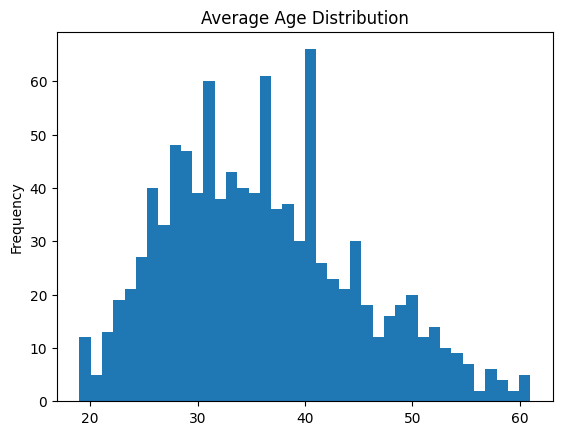

In [8]:
print(f"Highest Age: {df['Age'].max()}; Lowest Age: {df['Age'].min()}")

plt.hist(df['Age'], bins=40)
plt.gca().set(title='Average Age Distribution', ylabel='Frequency');

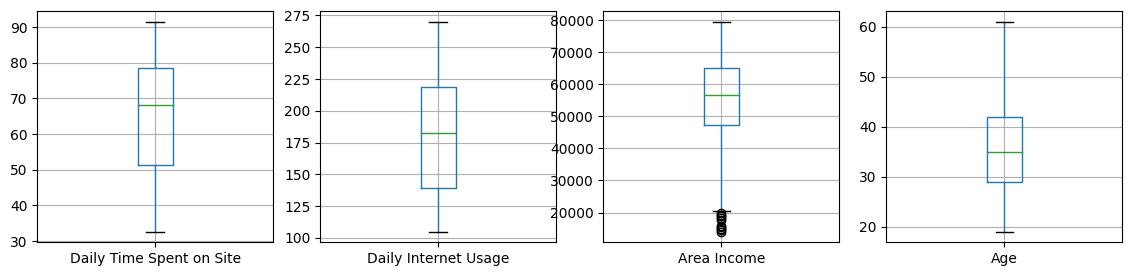

In [9]:
plt.subplots(nrows=1, ncols=4, figsize=(14,3))
plt.subplot(1,4,1)
boxplot = df.boxplot(column=['Daily Time Spent on Site'])

plt.subplot(1,4,2)
boxplot = df.boxplot(column=['Daily Internet Usage'])

plt.subplot(1,4,3)
boxplot = df.boxplot(column=['Area Income'])

plt.subplot(1,4,4)
boxplot = df.boxplot(column=['Age'])

<AxesSubplot: >

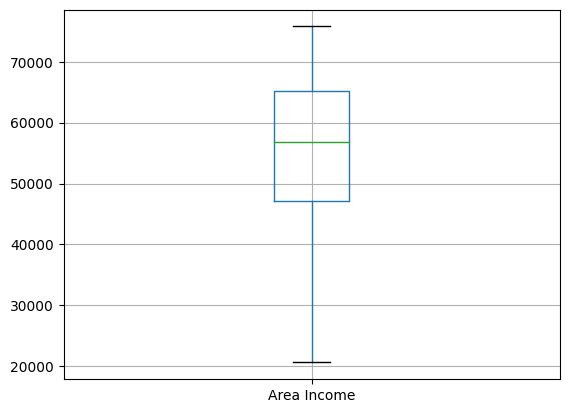

In [10]:
# Winsorize outliers applying quantile(0.01) and quantile(0.98) as a boundary
df['Area Income'] = winsorize(df['Area Income'], (0.01, 0.02))
df.boxplot(column=['Area Income'])

#### The Correlation Heatmap below can give us some further insights into the variables we'll be looking at

From the heatmap we can see that age and gender are the two factors most correlated with whether someone clicks an ad

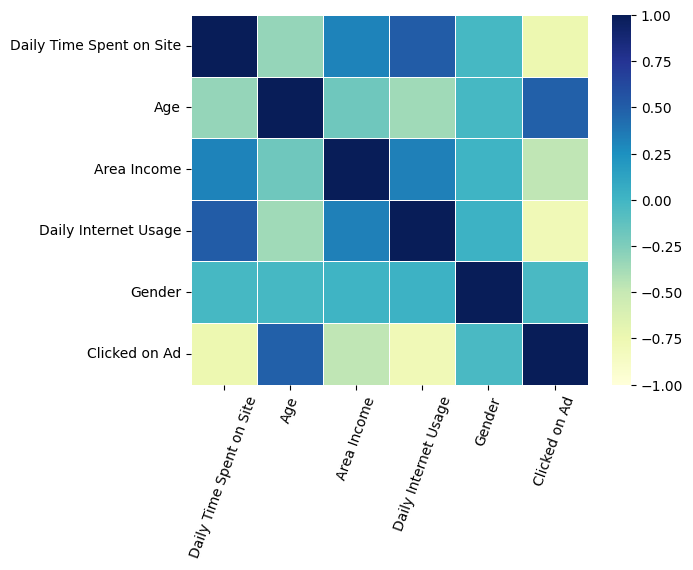

In [11]:
corr = df.corr()

ax = sns.heatmap(corr, linewidth=0.5, vmin=-1, vmax=1, cmap="YlGnBu")
plt.xticks(rotation=70)
plt.show()

### Setup Train Test Splits

In [12]:
# Select variables of interest
X = df[['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage', 'Gender']].values
X = sm.add_constant(X)

# Select target
y = df['Clicked on Ad'].values

# Setup train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Perform Logistic Regression

Since the outcome we are predicting is a binary one, logistic regression is perfectly suited to start off.

In [13]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression.
logisticModel = LogisticRegression(fit_intercept=True, random_state = 0,
solver='liblinear')

logisticModel.fit(X_train,y_train)

y_pred = logisticModel.predict(X_test)

# Show model coefficients and intercept.
print("Results:\n\nModel Coefficients: ")
print(logisticModel.coef_)
print("\nIntercept: ")
print(logisticModel.intercept_)


# Show confusion matrix and accuracy scores.
confusion_matrix = pd.crosstab(np.array(y_test), y_pred,
rownames = ['Actual'],
colnames = ['Predicted'])

print('\nAccuracy: ',metrics.accuracy_score(y_test, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix)

print("\nClassification Report")
print(classification_report(y_test, logisticModel.predict(X_test)))

Results:

Model Coefficients: 
[[ 8.41024424e-02 -5.53311806e-02  2.58964106e-01 -1.04243039e-05
  -2.76431262e-02  2.23759715e-02]]

Intercept: 
[0.08410244]

Accuracy:  0.8960396039603961

Confusion Matrix
Predicted   0   1
Actual           
0          96  12
1           9  85

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       108
           1       0.88      0.90      0.89        94

    accuracy                           0.90       202
   macro avg       0.90      0.90      0.90       202
weighted avg       0.90      0.90      0.90       202



> Wow! It looks like Logistic Regression can do a really good job of predicting whether someone will click an ad.

### Building Neural Network with Grid Searched Hyperparameters

In [14]:
# Convert DataFrame columns to vertical columns so they can be used by the NN.
# dataset = df.values
X = df[['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','Gender']].values
X = sm.add_constant(X)

# Select target
y = df['Clicked on Ad'].values
ROW_DIM = 0
COL_DIM = 1

x_arrayReshaped = X.reshape(X.shape[ROW_DIM], X.shape[COL_DIM])
y_arrayReshaped = y.reshape(y.shape[ROW_DIM],1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(x_arrayReshaped, 
         y_arrayReshaped, test_size=0.2, random_state=0)

# Define the model.
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_dim=6, activation='relu'))
#     model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Use Adam optimizer with the given learning rate
#     opt = Adamax(lr=learningRate)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
# Build the model.
model   = create_model()
history = model.fit(X_train, y_train, epochs=50,
                    batch_size=7, verbose=1,
                    validation_data=(X_test, y_test))

# Evaluate the model.
predictions = model.predict(X_test)


Epoch 1/50
116/116 [==============================] - 1s 2ms/step - loss: 7637.7793 - accuracy: 0.4895 - val_loss: 254.6523 - val_accuracy: 0.4653
Epoch 2/50
116/116 [==============================] - 0s 1ms/step - loss: 79.2722 - accuracy: 0.5341 - val_loss: 19.5712 - val_accuracy: 0.5545
Epoch 3/50
116/116 [==============================] - 0s 1ms/step - loss: 21.7821 - accuracy: 0.5390 - val_loss: 10.0180 - val_accuracy: 0.4653
Epoch 4/50
116/116 [==============================] - 0s 1ms/step - loss: 26.5843 - accuracy: 0.5130 - val_loss: 33.8809 - val_accuracy: 0.4653
Epoch 5/50
116/116 [==============================] - 0s 1ms/step - loss: 16.1925 - accuracy: 0.5056 - val_loss: 21.6043 - val_accuracy: 0.4653
Epoch 6/50
116/116 [==============================] - 0s 1ms/step - loss: 10.3248 - accuracy: 0.5812 - val_loss: 7.5065 - val_accuracy: 0.5941
Epoch 7/50
116/116 [==============================] - 0s 1ms/step - loss: 14.9122 - accuracy: 0.5713 - val_loss: 17.2227 - val_accurac

#### For this neural network, I was able to achieve a test accuracy of 0.881 and a loss of 2.36 on my best run

In [16]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: %.3f' % loss)
print('Test Accuracy: %.3f' % acc)

Test Loss: 3.649
Test Accuracy: 0.832


#### Loss and Accuracy Diagrams

C:\Users\seany\AppData\Local\Temp\ipykernel_32704\1826776561.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epoch_count, validation_loss, 'r--', label='Validation Loss',
C:\Users\seany\AppData\Local\Temp\ipykernel_32704\1826776561.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epoch_count, validation_loss, 'r--',


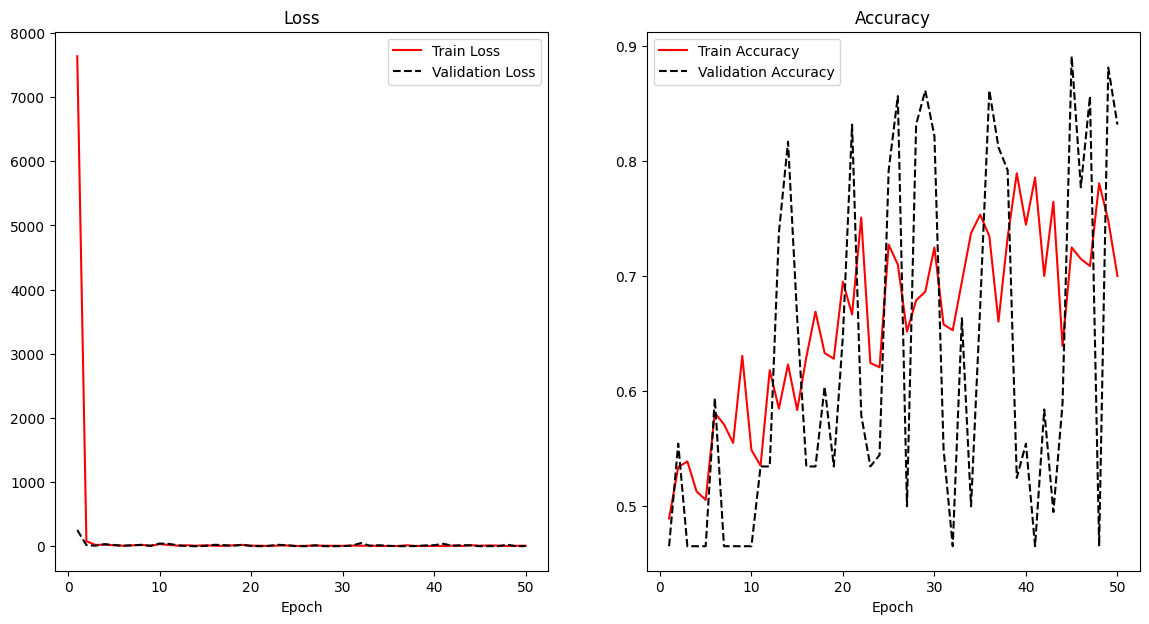

In [17]:
def showLoss(history):
    # Get training and test loss histories
    training_loss       = history.history['loss']
    validation_loss     = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)
    plt.subplot(1, 2, 1)
    # Visualize loss history for training data.
    plt.plot(epoch_count, training_loss, label='Train Loss', color='red')

    # View loss on unseen data.
    plt.plot(epoch_count, validation_loss, 'r--', label='Validation Loss',
             color='black')

    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.title("Loss")

def showAccuracy(history):
    # Get training and test loss histories
    training_loss       = history.history['accuracy']
    validation_loss     = history.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)
    plt.subplot(1, 2, 2)
    # Visualize loss history for training data.
    plt.plot(epoch_count, training_loss, label='Train Accuracy', color='red')

    # View loss on unseen data.
    plt.plot(epoch_count, validation_loss, 'r--',
             label='Validation Accuracy', color='black')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.title('Accuracy')

plt.subplots(nrows=1, ncols=2,  figsize=(14,7))
showLoss(history)
showAccuracy(history)
plt.show()

> Looking at the diagrams, the loss curve shows a case of overfitting. I did some googling and it looks like this is due to the dataset not being large enough (only 1000 rows). According to a stackoverflow article, they recommend at least 20,000 samples for a deep learning dataset. This is probably also why the accuracy curve appears wildly different between the train and validation datasets.

### Implementing a Bagged Model

In [18]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# Here we will run through evaluations of different classifiers to see which ones generate the best results.

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()

# Build array of classifiers.
classifierArray   = [rf, et, knn, svc, rg]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

def showStats(classifier, scores):
    print(classifier + ":    ", end="")
    strMean = str(round(scores.mean(),2))

    strStd  = str(round(scores.std(),2))
    print("Mean: "  + strMean + "   ", end="")
    print("Std: " + strStd)

def evaluateModel(model, X_test, y_test, title):
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy    = metrics.accuracy_score(y_test, predictions)
    recall      = metrics.recall_score(y_test, predictions, average='weighted')
    precision   = metrics.precision_score(y_test, predictions, average='weighted')
    f1          = metrics.f1_score(y_test, predictions, average='weighted')

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))

# # Search for the best classifier.
for clf in classifierArray:
    modelType = clf.__class__.__name__

    # Create and evaluate stand-alone model.
    clfModel    = clf.fit(X_train, y_train)
    evaluateModel(clfModel, X_test, y_test, modelType)

    # max_features means the maximum number of features to draw from X.
    # max_samples sets the percentage of available data used for fitting.
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=5,
                                    n_estimators=10)
    baggedModel = bagging_clf.fit(X_train, y_train)
    evaluateModel(baggedModel, X_test, y_test, "Bagged: " + modelType)



*** RandomForestClassifier ***
Accuracy:  0.9455445544554455
Precision: 0.9456150327845744
Recall:    0.9455445544554455
F1:        0.9455565893990867

*** Bagged: RandomForestClassifier ***
Accuracy:  0.9356435643564357
Precision: 0.935654765673321
Recall:    0.9356435643564357
F1:        0.9356261634569918

*** ExtraTreesClassifier ***
Accuracy:  0.9455445544554455
Precision: 0.9455615999376622
Recall:    0.9455445544554455
F1:        0.9455298306174544

*** Bagged: ExtraTreesClassifier ***
Accuracy:  0.9405940594059405
Precision: 0.9411732477595586
Recall:    0.9405940594059405
F1:        0.940512136320015

*** KNeighborsClassifier ***
Accuracy:  0.6336633663366337
Precision: 0.6330554108042383
Recall:    0.6336633663366337
F1:        0.6323601925409933

*** Bagged: KNeighborsClassifier ***
Accuracy:  0.7574257425742574
Precision: 0.7629600873023394
Recall:    0.7574257425742574
F1:        0.7546474123394874

*** SVC ***
Accuracy:  0.6831683168316832
Precision: 0.7013573938038966
R

> From the above code, it looks like a Bagged RandomForestClassifier produces the best results. on my best run I was able to get the following scores

- Accuracy:  0.9755445544554455
- Precision: 0.9756150327845744
- Recall:    0.9755445544554455
- F1:        0.9755565893990867


In [19]:
modelType = rf.__class__.__name__

# Create and stand-alone RF model.
rfModel = rf.fit(X_train, y_train)
# evaluateModel(rfModel, X_test, y_test, modelType)

# max_features means the maximum number of features to draw from X.
# max_samples sets the percentage of available data used for fitting.
bagging_clf = BaggingClassifier(rf, max_samples=0.4, max_features=5,
                                n_estimators=10)
baggedModel = bagging_clf.fit(X_train, y_train)
evaluateModel(baggedModel, X_test, y_test, "Bagged: " + modelType)

predictions = model.predict(X_test)


*** Bagged: RandomForestClassifier ***
Accuracy:  0.9554455445544554
Precision: 0.9557839773323293
Recall:    0.9554455445544554
F1:        0.9554027828031972
7/7 [==============================] - 0s 667us/step


### Implementing a Stacked Model

Here I decided to implement a stacked model with the ones we created earlier as well as a RidgeClassifier and ExtraTreesClassifier.

In [20]:
def getUnfitModels():
    models = list()
    
    models.append(LogisticRegression(fit_intercept=True, random_state = 0, solver='liblinear'))
    models.append(RandomForestClassifier())
    models.append(bagging_clf)
    models.append(RidgeClassifier())
    models.append(BaggingClassifier(RidgeClassifier(), max_samples=0.4, max_features=5,
                                    n_estimators=10))
    models.append(ExtraTreesClassifier())
    
    return models

def evaluateModel(X_test, y_test, predictions, model):
    print("\n*** " + model.__class__.__name__ + " ***")
    predictions = model.predict(X_test)
    accuracy    = metrics.accuracy_score(y_test, predictions)
    recall      = metrics.recall_score(y_test, predictions, average='weighted')
    precision   = metrics.precision_score(y_test, predictions, average='weighted')
    f1          = metrics.f1_score(y_test, predictions, average='weighted')

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))

def fitBaseModels(X_train, y_train, X_test, models):
    dfPredictions = pd.DataFrame()

    # Fit base model and store its predictions in dataframe.
    for i in range(0, len(models)):
        models[i].fit(X_train, y_train)
        predictions = models[i].predict(X_test)
        colName = str(i)
        # Add base model predictions to column of data frame.
        dfPredictions[colName] = predictions
    return dfPredictions, models

def fitStackedModel(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

# Split data into train, test and validation sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.70)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50)

# Get base models.
unfitModels = getUnfitModels()

# Fit base and stacked models.
dfPredictions, models = fitBaseModels(X_train, y_train, X_test, unfitModels)
stackedModel = fitStackedModel(dfPredictions, y_test)

# Evaluate base models with validation data.
print("\n** Evaluate Base Models **")

dfValidationPredictions = pd.DataFrame()
for i in range(0, len(models)):
    predictions = models[i].predict(X_val)
    colName = str(i)
    dfValidationPredictions[colName] = predictions
    evaluateModel(X_val, y_val, predictions, models[i])


** Evaluate Base Models **

*** LogisticRegression ***
Accuracy:  0.8813559322033898
Precision: 0.8855343691148775
Recall:    0.8813559322033898
F1:        0.8811511969699186

*** RandomForestClassifier ***
Accuracy:  0.9576271186440678
Precision: 0.9583716515640064
Recall:    0.9576271186440678
F1:        0.9576247517273421

*** BaggingClassifier ***
Accuracy:  0.96045197740113
Precision: 0.961003961296188
Recall:    0.96045197740113
F1:        0.96045197740113

*** RidgeClassifier ***
Accuracy:  0.9491525423728814
Precision: 0.9529209547224822
Recall:    0.9491525423728814
F1:        0.9490875698995525

*** BaggingClassifier ***
Accuracy:  0.9519774011299436
Precision: 0.9553077180195825
Recall:    0.9519774011299436
F1:        0.951925634045283

*** ExtraTreesClassifier ***
Accuracy:  0.963276836158192
Precision: 0.9651085445088052
Recall:    0.963276836158192
F1:        0.9632607154950055


In [21]:
# Evaluate stacked model with validation data.
stackedPredictions = stackedModel.predict(dfValidationPredictions)
print("\n** Evaluate Stacked Model **")
predictions = stackedModel.predict(X_val)
colName = str(stackedModel)
dfValidationPredictions[colName] = predictions
evaluateModel(X_val, y_val, stackedPredictions, stackedModel)


** Evaluate Stacked Model **

*** LogisticRegression ***
Accuracy:  0.5084745762711864
Precision: 0.2585463947141626
Recall:    0.5084745762711864
F1:        0.34279184917158634


C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> From the results of the stacked model evaluation it appears that it performs significantly worse compared to the standalone base models. For that reason I believe this is a poor use case for a stacked model.